# Astrostats Week 12: Other Methods
Nonnegative matrix factorization and independent component analysis are two other dimensionality reduction approaches that can sometimes Paraphrase(be better than pca in certain cicumstances when you know a few prior facts about your data, e.g. non-negative, independent sources, correlations, etc)

In [1]:
from sklearn.decomposition import PCA, FastICA, NMF 
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce

## Exercise: Compare "important components" found by NMF and PCA
Due to different constraints on the results, NMF and PCA will return different solutions to a similar matrix factorization problem. Sometimes, NMF can return components with more interesting features

In [2]:
from sklearn.decomposition import PCA, FastICA, NMF 
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce


# Convenient plotting function
def plot_gallery(title, images, n_col=3, n_row=3, cmap='gray'):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(int(np.sqrt(vec.size)), int(np.sqrt(vec.size))),
            cmap=cmap,
            interpolation="nearest",
            vmin=np.min(images),
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

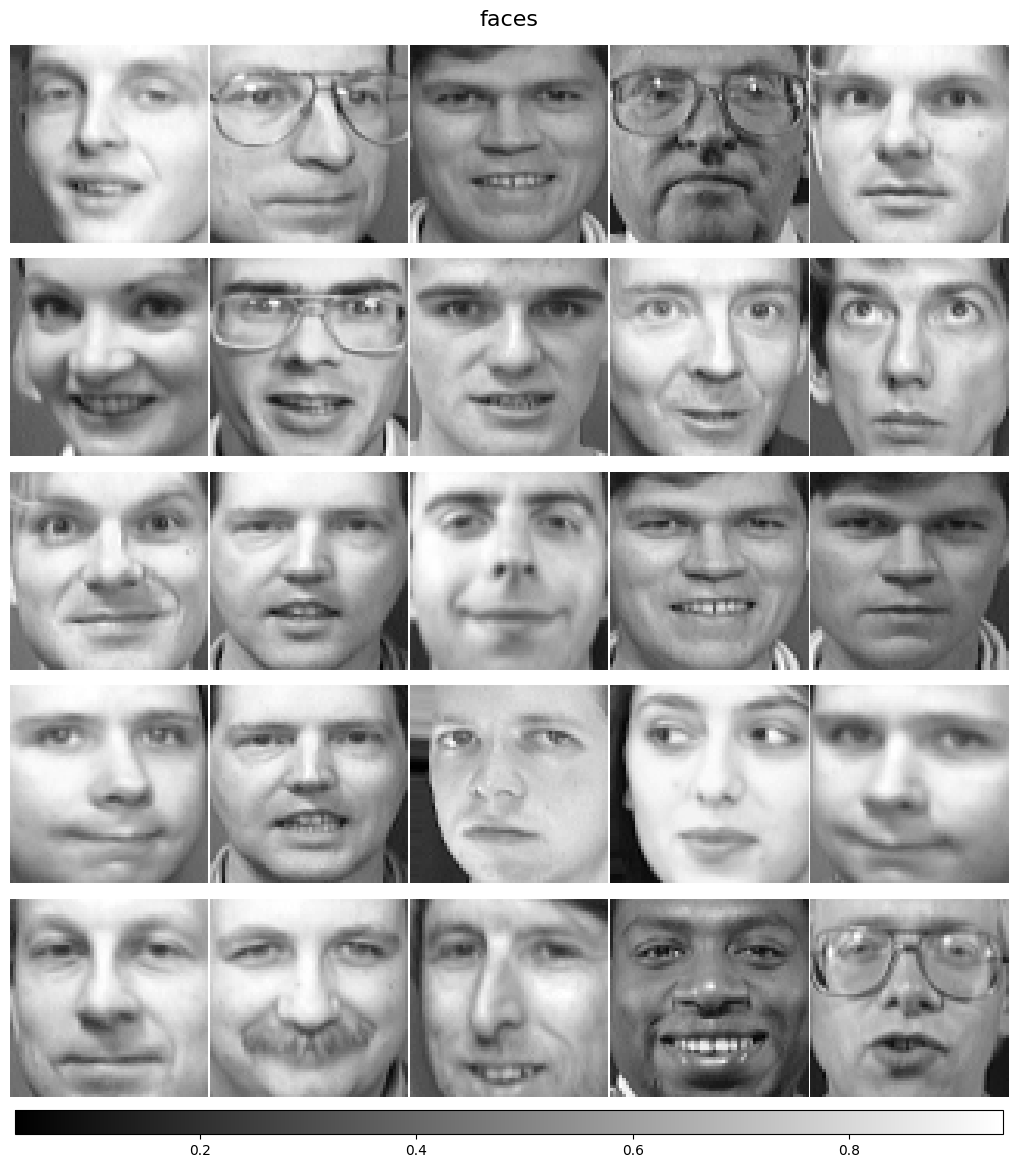

In [3]:
# get faces dataset
faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=1)
plot_gallery('faces', faces[:25], n_col=5, n_row=5)

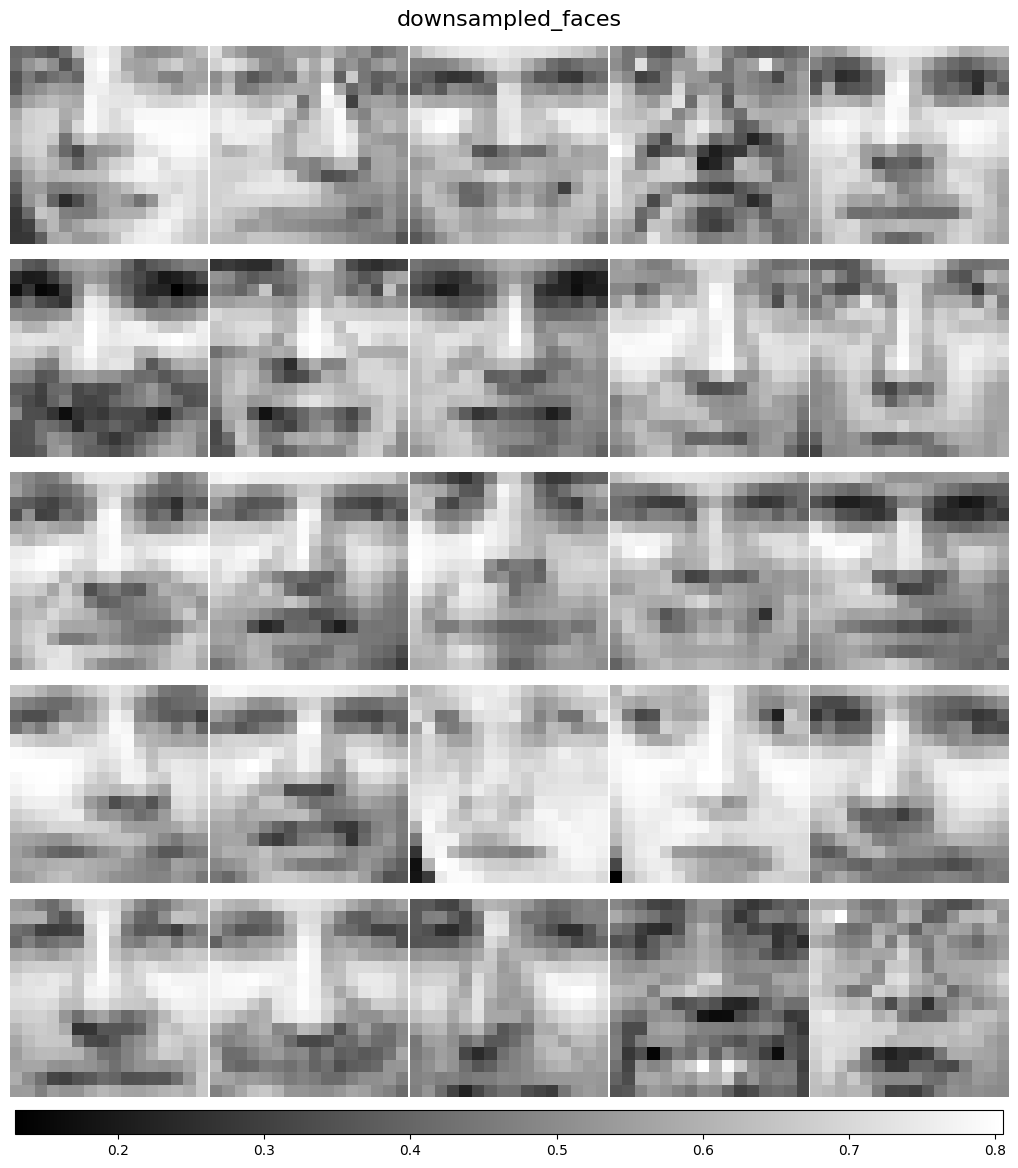

In [4]:
sqfaces = np.reshape(faces, (len(faces), 64, 64))
tmp = np.zeros((len(faces), 48, 48))
data = np.zeros((len(faces), 16,16))
for i in range(len(faces)):
    tmp[i] = sqfaces[i, 8:-8, 8:-8]
    data[i] = block_reduce(tmp[i], block_size=3, func=np.mean)

data = np.reshape(data, (len(faces), 16*16))

plot_gallery('downsampled_faces', data[:25], n_col=5, n_row=5)

In [5]:
nmf = NMF(n_components=25, max_iter=1000)
nmf.fit(data)
proj = nmf.transform(data)
comp = nmf.components_

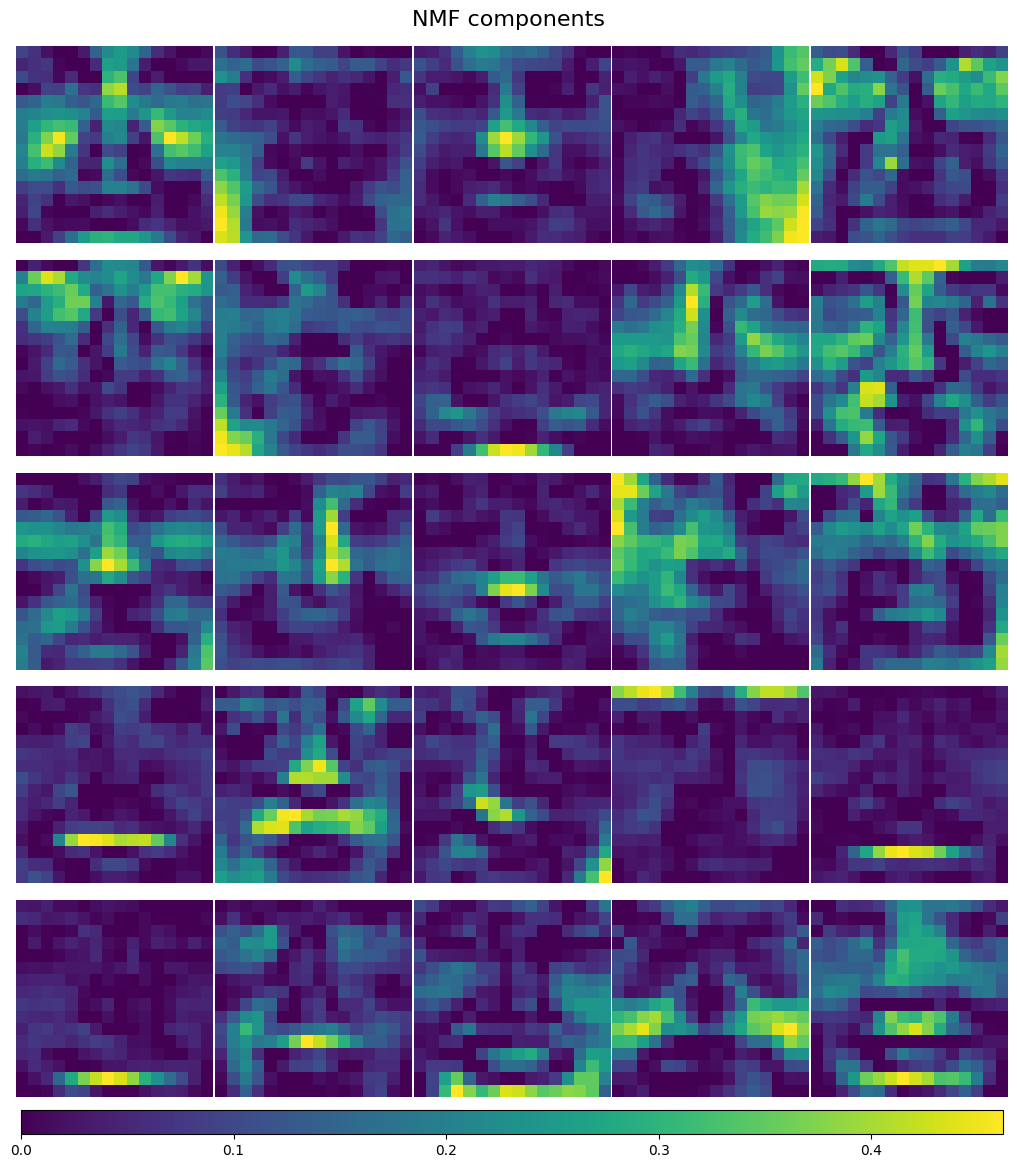

In [6]:
plot_gallery('NMF components', comp, n_col=5, n_row=5, cmap='viridis')


In [7]:
pca = PCA(n_components=200)
# pca.fit(faces-np.mean(faces))
pca.fit(data)
pcacomp = pca.components_
print(pcacomp.shape)

(200, 256)


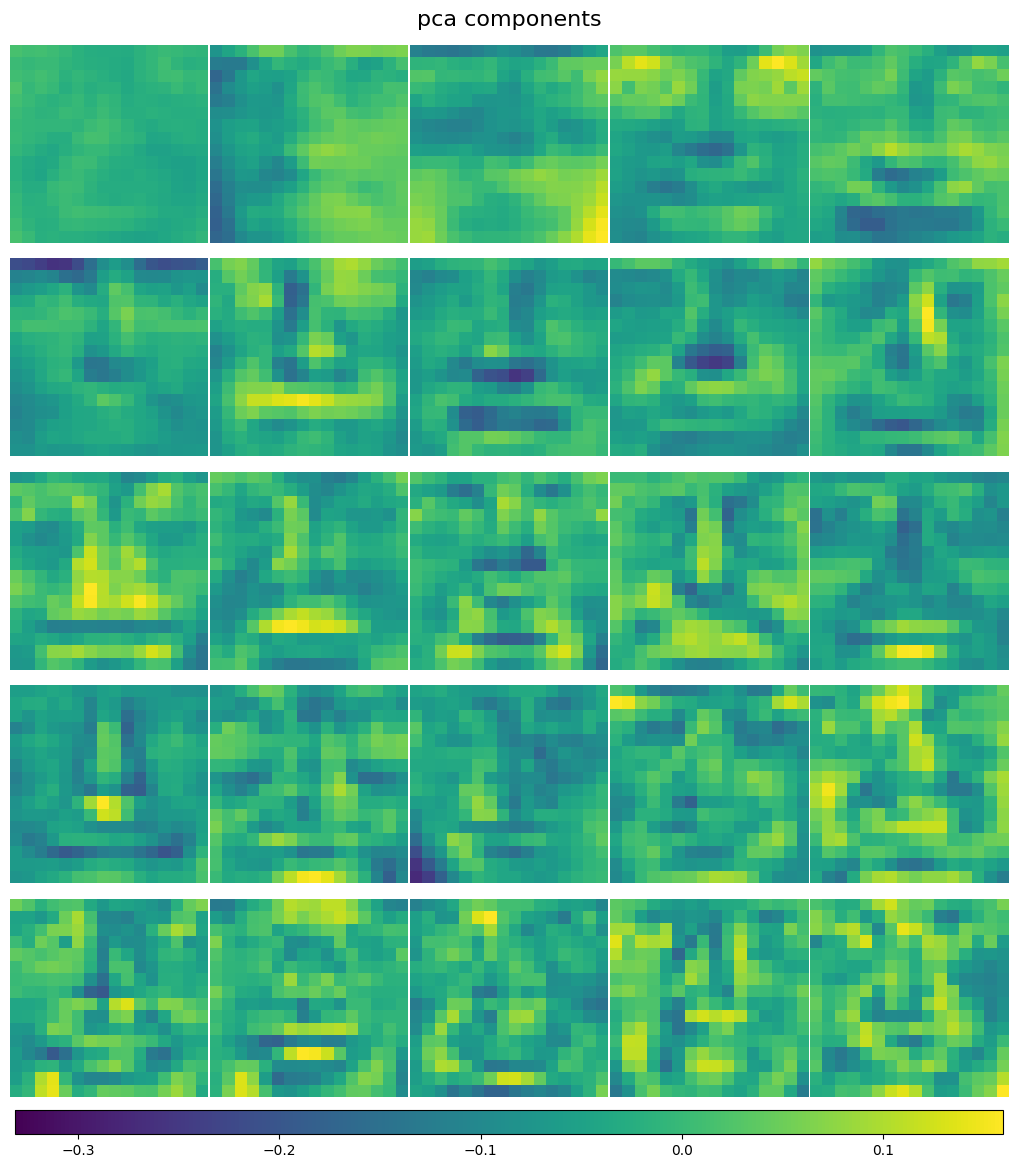

In [8]:
plot_gallery('pca components', pcacomp, n_row=5, n_col=5, cmap='viridis')


### maybe put this section first, before the NMF fits, and let people choose the number of NMF components first.
Try tuning the number of NMF components to fit. PCA calculates all the orthogonal principle components (limited by the SVD parameters), but NMF results can vary depending on the number of components set. How many components should you choose to use based on the PCA results?
<details>
  <summary>Hint 1:</summary>
    Try plotting the the variance and cumulative sum of PCA component variances. `pca.explained_variance_ratio_` gives the ratio of the variance explained by each PC.
</details>

<details>
  <summary>Hint 2:</summary>
    If there aren't any obvious elbow points in the variance plots, you can choose an arbitrary percentage of explained variance (e.g. 90%).
</details>
  
  

[28]


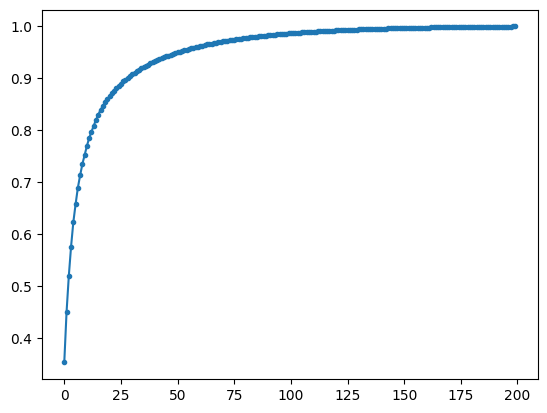

In [9]:
cumulative_var = np.cumsum(pca.explained_variance_ratio_)
print(np.argwhere(cumulative_var > 0.9)[0])
plt.figure()
plt.plot(cumulative_var, '.-')
plt.show()

Try changing the downsampling (or completely removing it) on the Olivetti faces dataset. The NMF components might not pick out the same facial features as components!

In [10]:
data = faces
nmf = NMF(n_components=25, max_iter=1000)
nmf.fit(data)
proj = nmf.transform(data)
comp = nmf.components_

pca = PCA(n_components=200)
pca.fit(data)
pcacomp = pca.components_
print(pcacomp.shape)

(200, 4096)


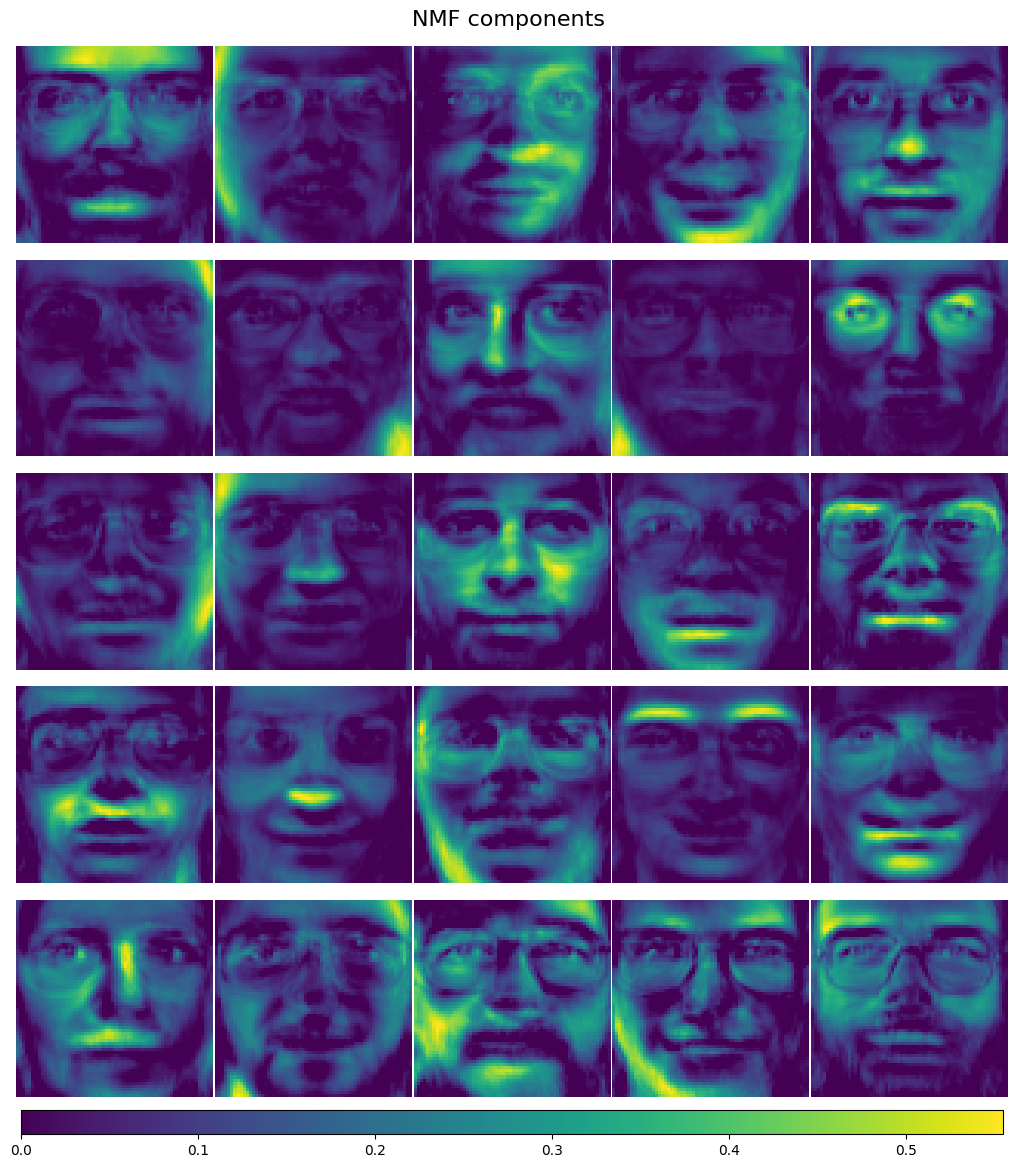

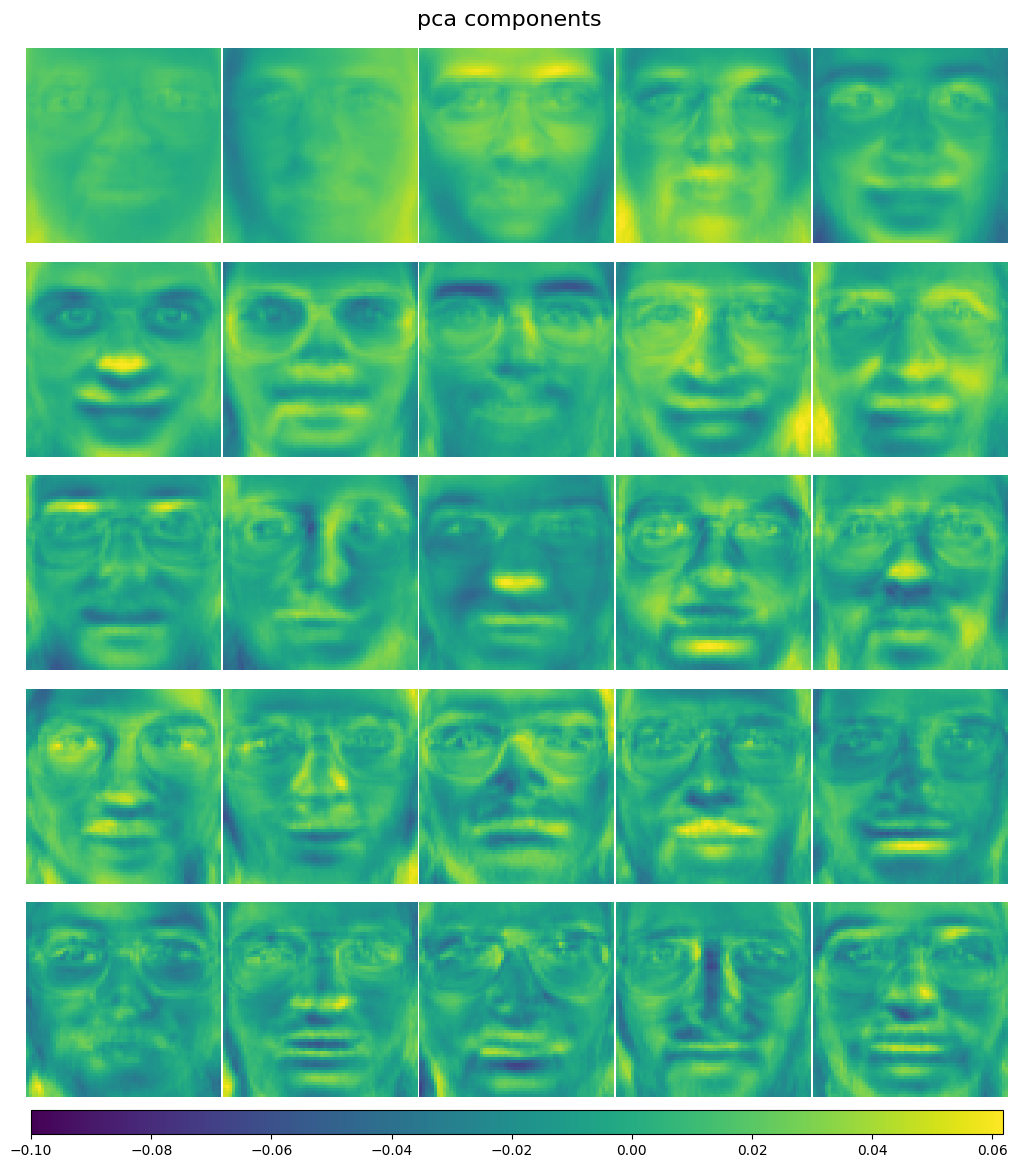

In [11]:
plot_gallery('NMF components', comp, n_col=5, n_row=5, cmap='viridis')

plot_gallery('pca components', pcacomp, n_row=5, n_col=5, cmap='viridis')


## Exercise: Unmixing linear combinations of waveforms with ICA
Let's create some sample data from random combinations of a few different waveforms. Use ICA to get the source signals back out of the combined waveforms. How does changing the number of components of the ICA fit affect result? Compare these 

Repeat the data generation, and both fitting methods a few times. Does ICA perform better on average than PCA? 

In [12]:
from scipy.signal import sawtooth, square

t = np.linspace(0, 2*np.pi, 200)
sine_wave = np.sin(t*15)
# square_wave = square(t*7)
saw_wave = -sawtooth(t*7)
tan_wave = np.sin(np.tan(t*4)/20)
noise = np.random.normal(0, 1, (200))

combination = np.random.uniform(0, 1, (100, 4))
functions_mat = np.stack([sine_wave, saw_wave, noise, tan_wave])
functions_mat.shape
data = (combination @ functions_mat) 
data = data - np.mean(data, axis=0) # data whitening

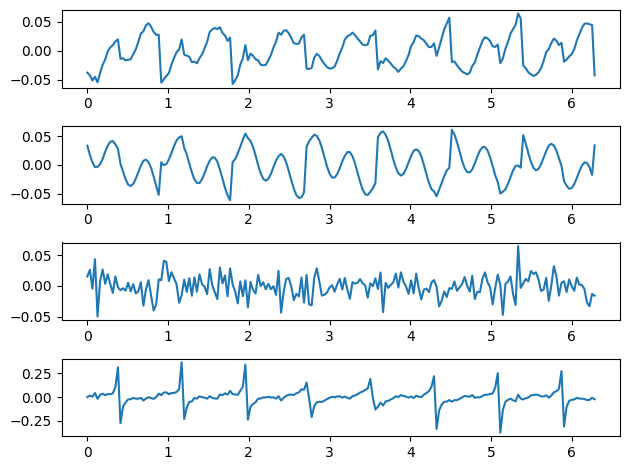

In [13]:
ica = FastICA(n_components=4, max_iter=1000)
ica.fit(data)

comp = ica.components_
plt.subplots(4,1)
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.plot(t, comp[i])
    plt.tight_layout()



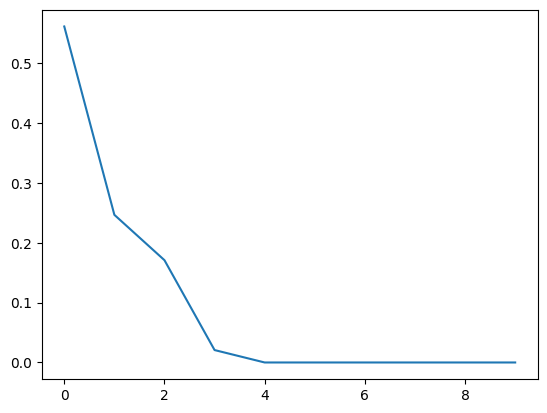

(100, 200)


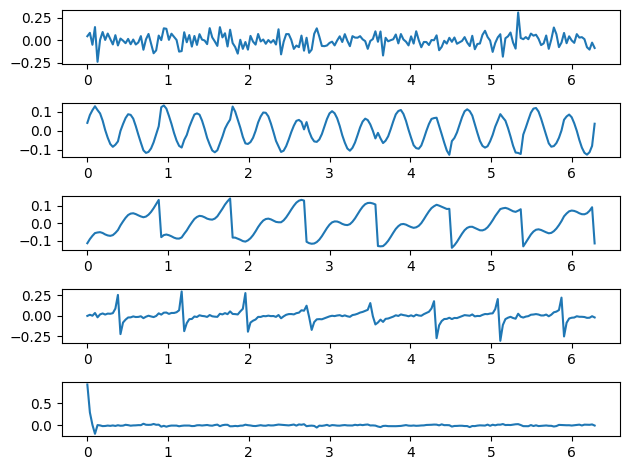

In [14]:
pca = PCA(n_components=100)
pca.fit(data)
comp = pca.components_

plt.figure()
plt.plot(pca.explained_variance_ratio_[:10])
plt.show()

print(comp.shape)
plt.subplots(5,1)
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(t, comp[i])
    plt.tight_layout()


## Exercise: unmixing mistery signals
`mystery.txt` is a dataset containing 100 different combinations of a few characteristic signals. Use any method of your choice from Monday or Wednesday to find the underlying patterns in the data!

<details>
  <summary>Hint:</summary>
    Try running components through IPython.display.Audio, as in `Audio(component, rate=9600)`
</details>
  



In [15]:
import glob
import scipy.io as io
from IPython.display import Audio
songs = glob.glob(r'C:\Users\teo\anaconda3\envs\remote\course_code\phys607exercises\*.wav')
dataset = []
for w in songs:
    dataset.append(io.wavfile.read(w)[1][:, 0])

newdata = np.zeros((6, 8640000))
for i, f in enumerate(dataset):
    print(songs[i])
    L = len(f)
    print(np.min(f), np.max(f))
    diff = L - 8640000
    start = diff//2
    stop = L - int(np.ceil(diff/2))
    f = f/np.max(f)
    newdata[i] = f[start:stop]
    print(np.max(newdata[i]))

C:\Users\teo\anaconda3\envs\remote\course_code\phys607exercises\fire.wav
-32768 32767
1.0
C:\Users\teo\anaconda3\envs\remote\course_code\phys607exercises\gaga.wav
-20822 20237
1.0
C:\Users\teo\anaconda3\envs\remote\course_code\phys607exercises\mozart.wav
-10811 10551
1.0
C:\Users\teo\anaconda3\envs\remote\course_code\phys607exercises\silk_sonic.wav
-31786 31377
1.0
C:\Users\teo\anaconda3\envs\remote\course_code\phys607exercises\stromae.wav
-32768 32767
1.0
C:\Users\teo\anaconda3\envs\remote\course_code\phys607exercises\teriyaki.wav
-32768 32767
1.0


In [39]:
s = newdata[4, ::5]
Audio(s, rate=int(48000/5))

In [41]:
# data = np.zeros((60, 48000*3))
# for i in range(60):
#     data[i] = mix[i*48000*3:(i+1)*48000*3]

first = newdata[:, :8640000//2:]
second = newdata[:, 8640000//2:]
second[4] = first[4]

# mix1 = np.random.uniform(-1 ,1, (100, 6)) @ first
mix2 = np.random.uniform(-1 ,1, (100, 6)) @ second



# mix1 = mix1 / np.max(mix1)
mix2 = mix2 / np.max(mix2)

dataset=mix2[:, ::5]
dataset = dataset.astype(np.float16)
dataset.nbytes


172800000

In [42]:
np.save('mistery.npy', dataset[:, :108000])

In [43]:
dataset = np.load(r'C:\Users\teo\anaconda3\envs\remote\course_code\phys607exercises\mistery.npy')
dataset

array([[-0.03075, -0.02826, -0.101  , ...,  0.146  ,  0.1567 ,  0.0893 ],
       [-0.1445 , -0.0932 , -0.04742, ...,  0.1096 ,  0.138  ,  0.07263],
       [-0.129  , -0.08795, -0.02213, ..., -0.02719,  0.0315 ,  0.0541 ],
       ...,
       [-0.0641 , -0.1414 , -0.177  , ..., -0.1456 , -0.03122,  0.05936],
       [ 0.0561 ,  0.04474, -0.02596, ...,  0.1375 ,  0.1067 ,  0.01441],
       [-0.0654 , -0.02193,  0.07434, ..., -0.1057 , -0.1686 , -0.0741 ]],
      dtype=float16)

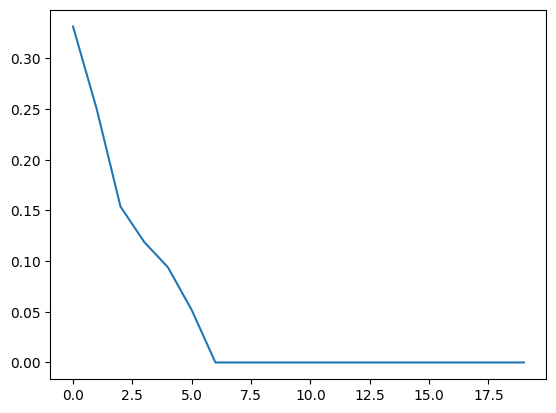

(50, 108000)


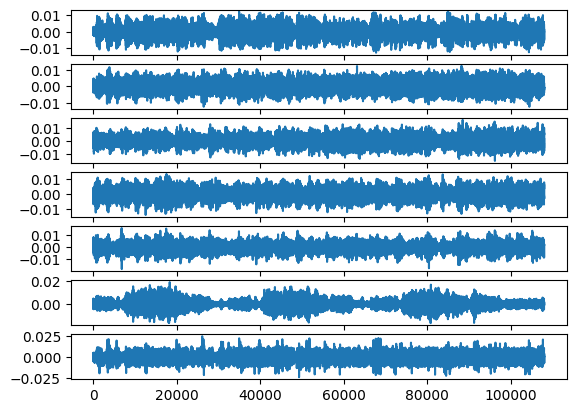

In [44]:
pca = PCA(n_components=50)
pca.fit(dataset)
pcacomp = pca.components_ 

plt.figure()
plt.plot(pca.explained_variance_ratio_[:20])
plt.show()

print(pcacomp.shape)
plt.subplots(7,1)
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(pcacomp[i])



In [50]:
Audio(pcacomp[5], rate=9600)


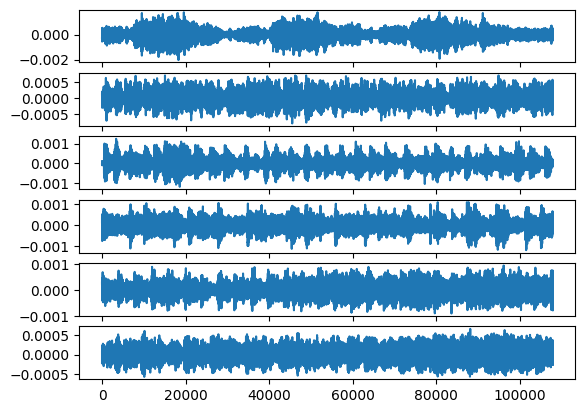

In [51]:
n= 6
ica = FastICA(n_components=n, max_iter=1000)
ica.fit(dataset)

icacomp = ica.components_#/np.max(ica.components_, axis=0)
plt.subplots(n,1)
for i in range(n):
    plt.subplot(n, 1, i+1)
    plt.plot(icacomp[i])
    # plt.tight_layout()



In [57]:
Audio(icacomp[0], rate=9600)